# Práctica 3 - Ejercicio 1

Asignatura: Programación para la Inteligencia Artificial

Alumno:- Laura Mondéjar Ruiz

Típicamente el Aprendizjae Profundo se utiliza en problemas supervisados (conocemos la entrada y la salida para los datos de entrenamiento, validación y test). Este planteamiento tiene el problema de requerir que los datos hayan sido previamente etiquetados. Sin embargo, hay modelos neuronales que no tienen esta restricción.

Un Autocodificador (*Autoencoder*) es una red neuronal que se entrena para aprender la función identidad. Típicamente se puede dividir en dos secciones simétricas: una primera parte que codifica progresivamente la entrada a un espacio de menos dimensiones (denominado espacio latente) y una segunda parte que decodifica de vuelta al espacio de dimensiones original.

$x = d_{\theta_{1}}(e_{\theta_{2}}(x))$

Como aprende la función identidad, no requiere etiquetado para su entrenamiento.

Un Autocodificador con eliminación de ruido (*Denoising Autoencoder*) es una red neuronal que se entrena para eliminar el ruido de unos datos de entrada.

$x = d_{\theta_{1}}(e_{\theta_{2}}(\hat{x}))$

El objetivo de esta práctica es definir y entrenar un Autocodificar con eliminación de ruido capaz de lidiar con ruido gaussiano de media $\mu=0$ y desviación típica $\sigma=0.2$ para el conjunto de datos Fashion-MNIST (https://docs.pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html). El autocodificador debe componerse de neuronas lineales y el espacio latente debe ser de 8 dimensiones.

Para evaluar la efectividad del modelo entrenado se deben utilizar todos los ejemplos del conjunto de test y el error absoluto. Se recomienda incluir el código necesario para mostrar un ejemplo cualquiera del conjunto de test con ruido, sin ruido y el resultado del autocodificador.

Una vez entrenado, se debe mostrar la relación entre las componentes de las codificaciones del conjunto de test con la clase asociada a dichas codificaciones. Se recomienda hacer gráficas 2D cuyos ejes muestren los valores de 2 componentes y muestren la clase como el color de cada punto.

El cuaderno entregado debe llamarse ApellidosNombrePractica3Ejercicio1.ipynb

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
device_gpu = torch.device("cuda")

In [2]:
from google.colab import drive
drive.mount('/content/drive')
ruta = '/content/drive/MyDrive/PIA/fachionMNIST'

train_dataset = datasets.FashionMNIST( root=ruta, train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.FashionMNIST(root=ruta, train=False, download=True, transform=transforms.ToTensor())

#clase personalizada con ruido
class DatasetConRuido(Dataset):
  def __init__(self, dataset_original, noise = 0.2):
    self.dataset = dataset_original
    self.noise = noise

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    clean_img, label = self.dataset[idx]

    #Generar ruido gausiano
    noise = torch.randn(clean_img.shape) * self.noise

    noisy_img = clean_img + noise
    noisy_img = torch.clamp(noisy_img, 0., 1.)
    return noisy_img, clean_img, label


def split_dataset(dataset, split_share=0.5):
  """
  Devuelve dos subconjuntos del dataset. split_share define cuántos ejemplos irán al
  primer subconjunto. El resto irán al segundo.
  """
  mask_indices_to_first_subset = torch.rand(len(dataset))<=split_share
  indices_first_subset = [i for i, _ in enumerate(dataset) if mask_indices_to_first_subset[i]]
  indices_second_subset = [i for i, _ in enumerate(dataset) if not mask_indices_to_first_subset[i]]

  first_subset = torch.utils.data.Subset(dataset, indices_first_subset)
  second_subset = torch.utils.data.Subset(dataset, indices_second_subset)

  return first_subset, second_subset


train_dataset, val_dataset = split_dataset(train_dataset, split_share=0.8)


train_noisy_dataset = DatasetConRuido(train_dataset, noise = 0.2)
test_noisy_dataset = DatasetConRuido(test_dataset, noise = 0.2)
val_noisy_dataset = DatasetConRuido(val_dataset, noise = 0.2)
print(f"Número de ejemplos en entrenamiento: {len(train_noisy_dataset)}")
print(f"Número de ejemplos en validación: {len(val_noisy_dataset)}")
print(f"Número de ejemplos en test: {len(test_noisy_dataset)}")


def preload_data_to_tensors(dataloader):
    noisy_img, clean_img, label = [], [], []
    for x, y, z in dataloader:
        noisy_img.append(x)
        clean_img.append(y)
        label.append(z)
    X = torch.cat(noisy_img)
    Y = torch.cat(clean_img)
    Z = torch.cat(label)
    return X, Y, Z


#Parametros
batch_size = 1024
learning_rate = 1e-3
epochs = 200
loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.Adam
validation_freq = 1

train_dataloader = DataLoader(train_noisy_dataset, batch_size, shuffle=True)
val_dataloader = DataLoader(val_noisy_dataset, batch_size, shuffle=True)
test_dataloader = DataLoader(test_noisy_dataset, batch_size, shuffle=False)

#Precargar datos
train_noisy, train_clean, train_labels = preload_data_to_tensors(train_dataloader)
val_noisy, val_clean, val_labels = preload_data_to_tensors(val_dataloader)
test_noisy, test_clean, test_labels = preload_data_to_tensors(test_dataloader)

train_noisy_dataset = torch.utils.data.TensorDataset(train_noisy.to(device_gpu), train_clean.to(device_gpu), train_labels.to(device_gpu))
val_noisy_dataset = torch.utils.data.TensorDataset(val_noisy.to(device_gpu), val_clean.to(device_gpu), val_labels.to(device_gpu))
test_noisy_dataset = torch.utils.data.TensorDataset(test_noisy.to(device_gpu), test_clean.to(device_gpu), test_labels.to(device_gpu))

train_dataloader= DataLoader(train_noisy_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_noisy_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_noisy_dataset, batch_size=batch_size, shuffle=False)



Mounted at /content/drive
Número de ejemplos en entrenamiento: 48057
Número de ejemplos en validación: 11943
Número de ejemplos en test: 10000


In [3]:
class Autoencoder(nn.Module):
  def __init__(self):
    super().__init__()

    #ENCODER
    self.encoder = nn.Sequential(
        nn.Flatten(), #Aplanamos la imagen para que tenga el formato que Linear acepta
        nn.Linear(28*28, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 8) #Establecemos el espacio latente de 8 dimensiones
    )

    #DECODER
    self.decoder = nn.Sequential(
        nn.Linear(8, 64),
        nn.ReLU(),
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Linear(128, 28*28),
        nn.Sigmoid() #Para que la salida esté entre 1 y 0
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)

    #Desaplanar
    decoded = decoded.view(-1, 1, 28, 28)

    return decoded, encoded


In [4]:
#Bucle entrenamiento

def learning_loop(train_dataloader, val_dataloader, model, epochs, loss_fn, learning_rate, optimizer, validation_freq, device):
  epoch_loss_list = []
  val_loss_list = []

  model = model.to(device)

  opt = optimizer(
    model.parameters(),
    lr=learning_rate
  )

  with tqdm(range(epochs), desc="epoch:") as pbar:
    for epoch in pbar:
      # Entrenamiento
      steps_loss_list = []
      for noisy_img, clean_img, _ in train_dataloader:
        #Mover los datos al dispositivo
        noisy_img = noisy_img.to(device)
        clean_img = clean_img.to(device)


        reconstruida, _ = model(noisy_img)                  # Forward
        opt.zero_grad()
        loss = loss_fn(reconstruida, clean_img)
        loss.backward()                                     # Backward
        steps_loss_list.append(loss.clone().detach())
        opt.step()

      train_loss = torch.tensor(steps_loss_list).mean()
      epoch_loss_list.append(train_loss)
      pbar.set_postfix(loss=f"{train_loss}")

      #Validación
      if epoch%validation_freq==0:
        val_step_loss_list = []

        with torch.no_grad():
          for noisy_img, clean_img, _ in val_dataloader:

            # Mover los datos al dispositivo
            noisy_img = noisy_img.to(device)
            clean_img = clean_img.to(device)

            reconstruido, _ = model(noisy_img)

            loss_val = loss_fn(reconstruido, clean_img)
            val_step_loss_list.append(loss_val)

          val_loss = torch.tensor(val_step_loss_list).mean()
          val_loss_list.append(val_loss)

          #Actualizar barra de progreso
          pbar.set_postfix(train_loss=f"{train_loss:.4f}", val_loss=f"{val_loss:.4f}")

  return model, epoch_loss_list, val_loss_list


epoch:: 100%|██████████| 200/200 [03:10<00:00,  1.05it/s, train_loss=0.0659, val_loss=0.0669]


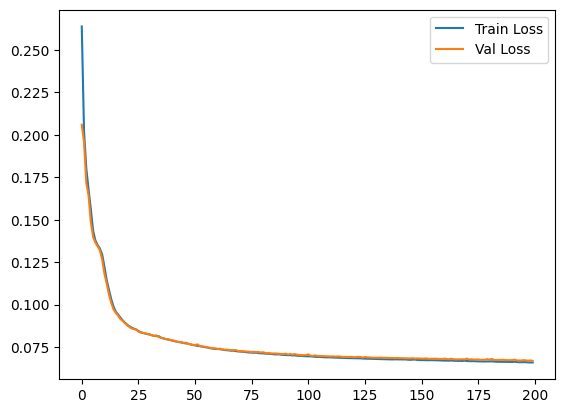

In [5]:
#EJECUCIÓN
model = Autoencoder().to(device_gpu)
model, train_loss, val_loss= learning_loop(
    train_dataloader,
    val_dataloader,
    model,
    epochs,
    loss_fn,
    learning_rate,
    optimizer,
    validation_freq = validation_freq, device= device_gpu)

#Grafica errores
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend()
plt.show()


Error Medio en Test: 0.0674


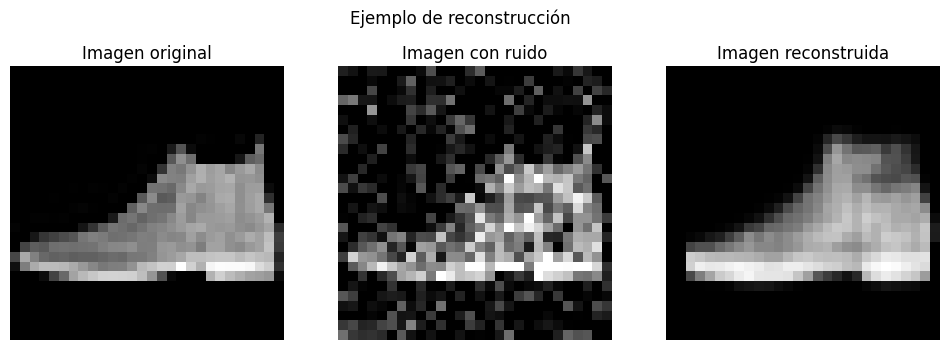

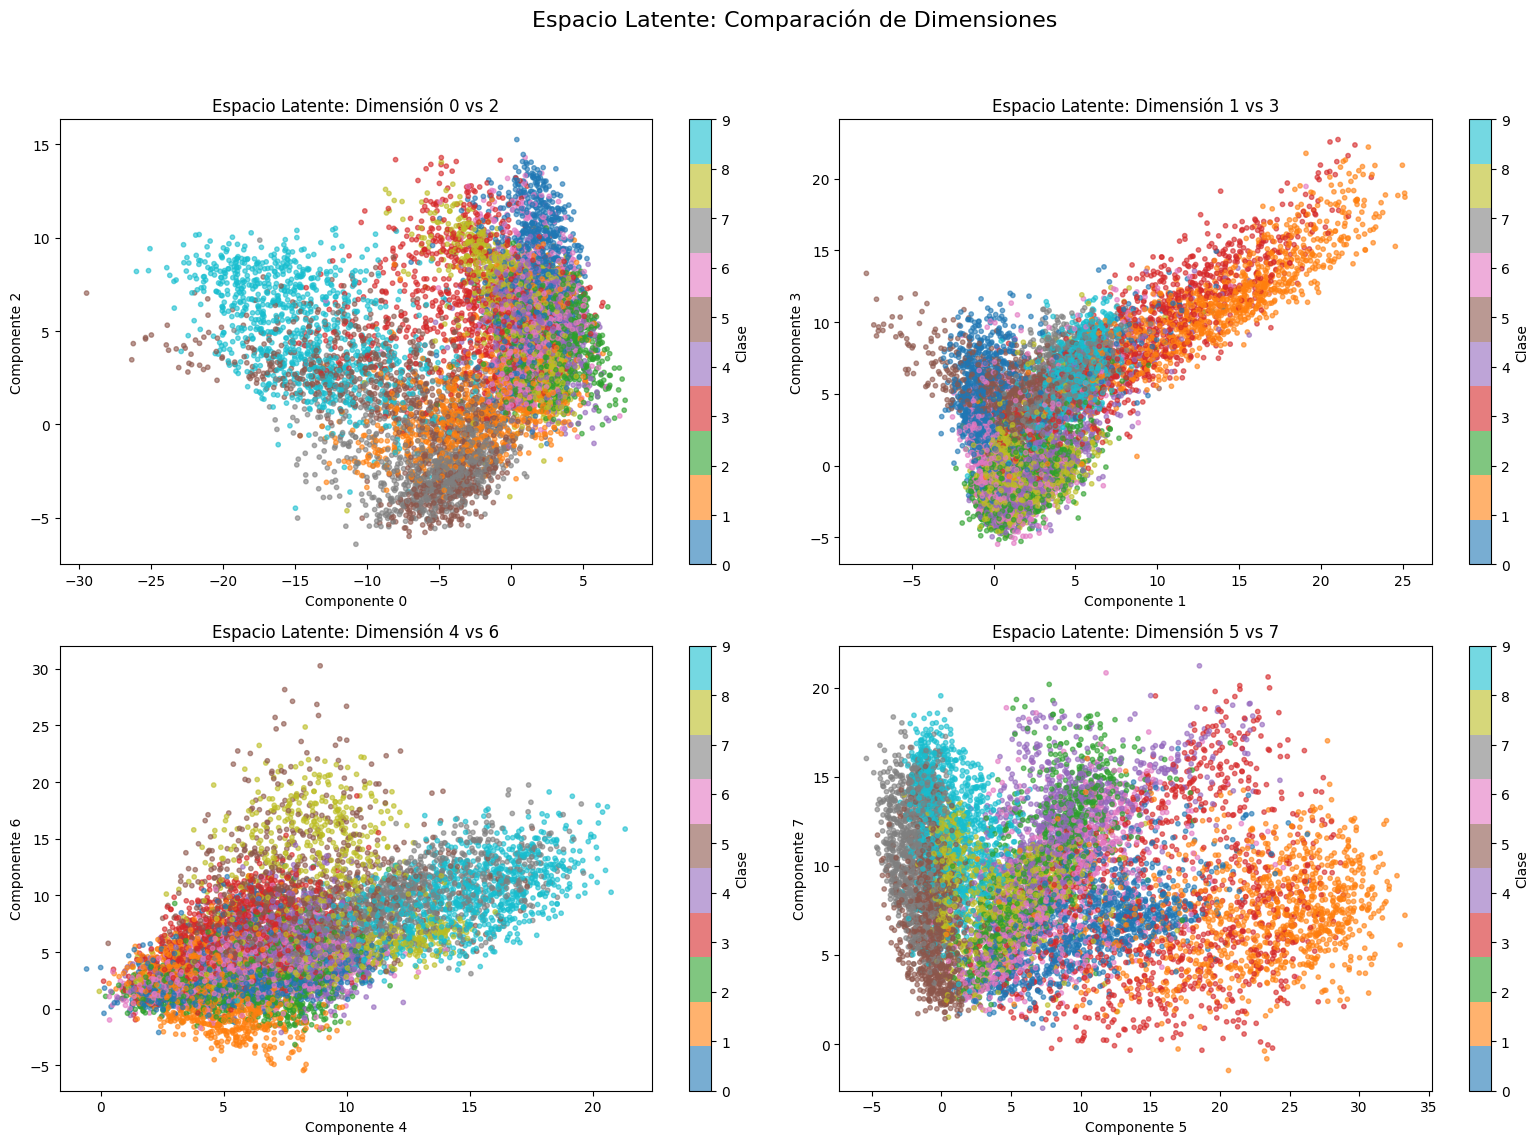

In [6]:
#Evaluación y visualización
total_loss = 0.0
latentes = []
labels = []

example_data = None

with torch.no_grad():
  for noisy_img, clean_img, label in test_dataloader:
    noisy_img = noisy_img.to(device_gpu)
    clean_img = clean_img.to(device_gpu)

    reconstruido, codificacion = model(noisy_img)

    loss = loss_fn(reconstruido, clean_img)
    total_loss += loss.item()

    latentes.append(codificacion.cpu())
    labels.append(label.cpu())

    if example_data is None:
      example_data = (clean_img.cpu(), noisy_img.cpu(), reconstruido.cpu())

error = total_loss / len(test_dataloader)
print(f"Error Medio en Test: {error:.4f}")


#Ejemplo reconstrucción
clean_img, noisy_img, reconstruido = example_data
idx = 0
clean_img = clean_img[idx].squeeze()
noisy_img = noisy_img[idx].squeeze()
reconstruido = reconstruido[idx].squeeze()

plt.figure(figsize=(12, 4))
plt.suptitle("Ejemplo de reconstrucción")

#imagen original
plt.subplot(1, 3, 1)
plt.title("Imagen original")
plt.imshow(clean_img, cmap='gray')
plt.axis('off')

#imagen con ruido
plt.subplot(1, 3, 2)
plt.title("Imagen con ruido")
plt.imshow(noisy_img, cmap='gray')
plt.axis('off')

#imagen reconstruida
plt.subplot(1, 3, 3)
plt.title("Imagen reconstruida")
plt.imshow(reconstruido, cmap='gray')
plt.axis('off')

plt.show()





#ESPACIOS LATENTES
latentes = torch.cat(latentes)
labels = torch.cat(labels)

fig, axs = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("Espacio Latente: Comparación de Dimensiones", fontsize=16, y=0.98)
axs = axs.flatten()

#Dim 0 vs 2
scatter1 = axs[0].scatter(latentes[:, 0], latentes[:, 2], c=labels, cmap='tab10', s=10, alpha=0.6)
axs[0].set_title('Espacio Latente: Dimensión 0 vs 2')
axs[0].set_xlabel('Componente 0')
axs[0].set_ylabel('Componente 2')
plt.colorbar(scatter1, ax=axs[0], label='Clase')

#Dim 1 vs 3
scatter2 = axs[1].scatter(latentes[:, 1], latentes[:, 3], c=labels, cmap='tab10', s=10, alpha=0.6)
axs[1].set_title('Espacio Latente: Dimensión 1 vs 3')
axs[1].set_xlabel('Componente 1')
axs[1].set_ylabel('Componente 3')
plt.colorbar(scatter2, ax=axs[1], label='Clase')

#Dim 4 vs 6
scatter3 = axs[2].scatter(latentes[:, 4], latentes[:, 6], c=labels, cmap='tab10', s=10, alpha=0.6)
axs[2].set_title('Espacio Latente: Dimensión 4 vs 6')
axs[2].set_xlabel('Componente 4')
axs[2].set_ylabel('Componente 6')
plt.colorbar(scatter3, ax=axs[2], label='Clase')

#Dim 5 vs 7
scatter4 = axs[3].scatter(latentes[:, 5], latentes[:, 7], c=labels, cmap='tab10', s=10, alpha=0.6)
axs[3].set_title('Espacio Latente: Dimensión 5 vs 7')
axs[3].set_xlabel('Componente 5')
axs[3].set_ylabel('Componente 7')
plt.colorbar(scatter4, ax=axs[3], label='Clase')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
